In [107]:
import os

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import sctm
import squidpy as sq

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
adata = sc.read_h5ad("adata.h5ad")

Here, we visualize the ground truth topics

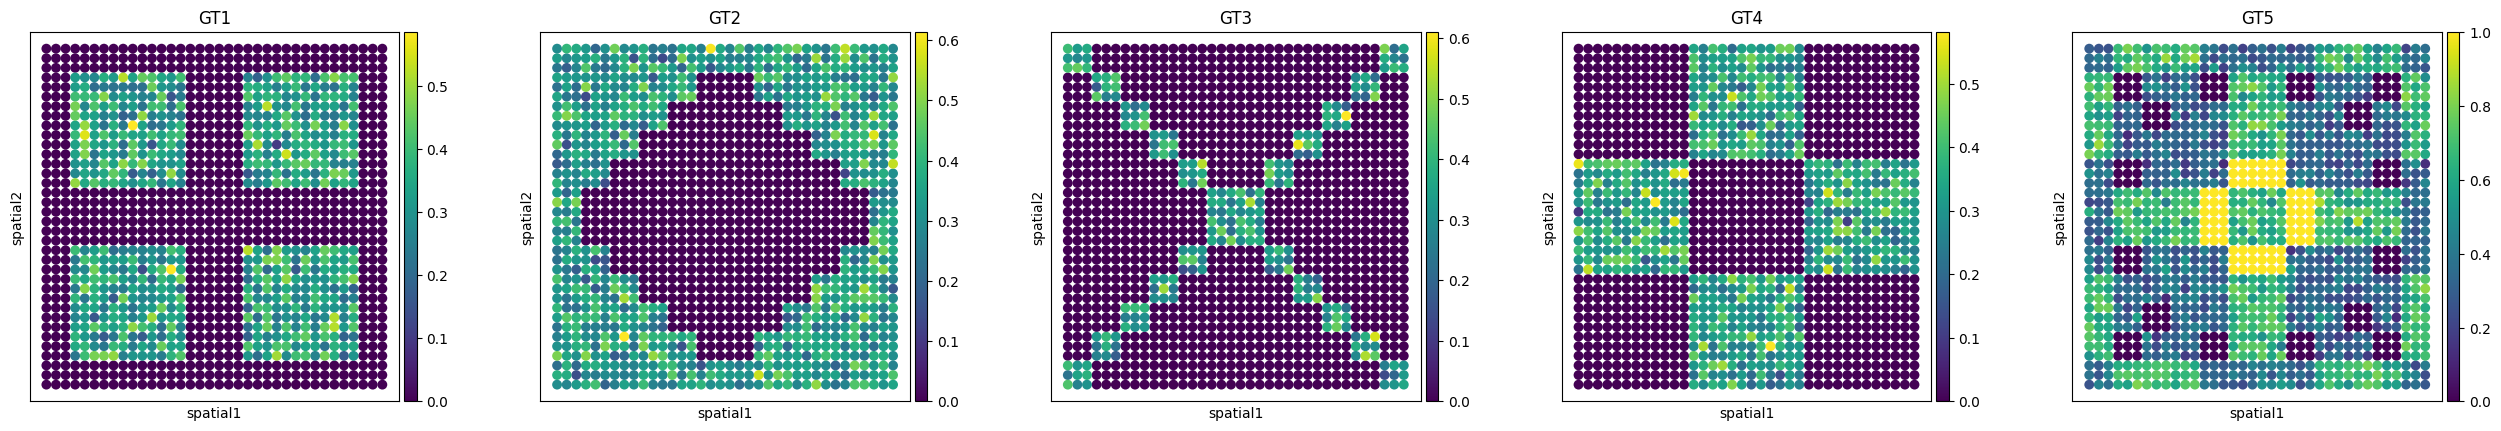

In [8]:
gt = pd.DataFrame(adata.obsm['spfac'], index = adata.obs_names, columns = [f"GT{i}" for i in range(1,6)])
for i in gt.columns:
    adata.obs[i] = gt[i]
sctm.pl.spatial(adata, color = gt.columns, size = 200, ncols = 5, wspace = 0)

Here, we visualized some of the genes/features in our data. Most of them are a combination of one of the pattern above. Some of them are empty like feature 0. Feature 2 for example is a combination of the GT3 and GT4

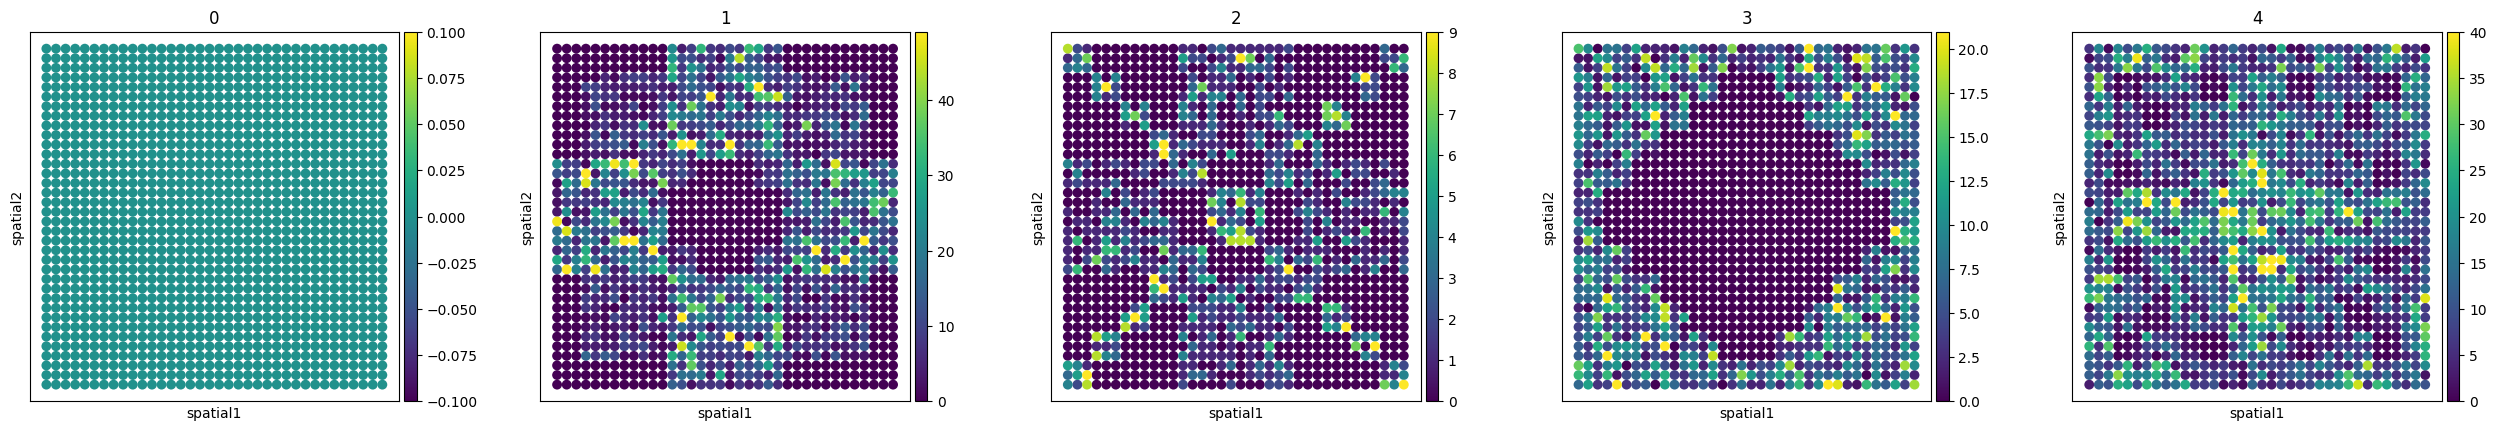

In [121]:
sctm.pl.spatial(adata, color = adata.var_names[:5], ncols = 5, size = 200, vmax = 'p99', wspace =0,
               layer = 'counts')

In [116]:
sctm.seed.seed_everything(0)
sq.gr.spatial_neighbors(adata, n_neighs=8)
model = sctm.stamp.STAMP(adata, 5, layer = "counts", gene_likelihood ='nb')
model.train(learning_rate = 0.01, batch_size = 1296, shuffle = True, min_epochs = 800)

Computing background frequencies


  0%|                                                                                                                                     | 0/800 [00:00<?, ?it/s]/home/chengwei/miniconda3/envs/torch/lib/python3.9/site-packages/pyro/primitives.py:443: UserWarning: encoder.norm_topic.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
Epoch Loss:802.594: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:21<00:00,  9.84it/s]


STAMP gives two different outputs. The topic prop gets us the latent topic proportions, 
and the beta gives us the gene modules via get_cell_by_topic() and get_feature_by_topic() respectively.

In [117]:
topic_prop = model.get_cell_by_topic()
# We used a higher psuedocount that usual as there are a higher amount of genes that have no expression 
# in this simualtion data than actual data
beta = model.get_feature_by_topic(pseudocount = 0.3)
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

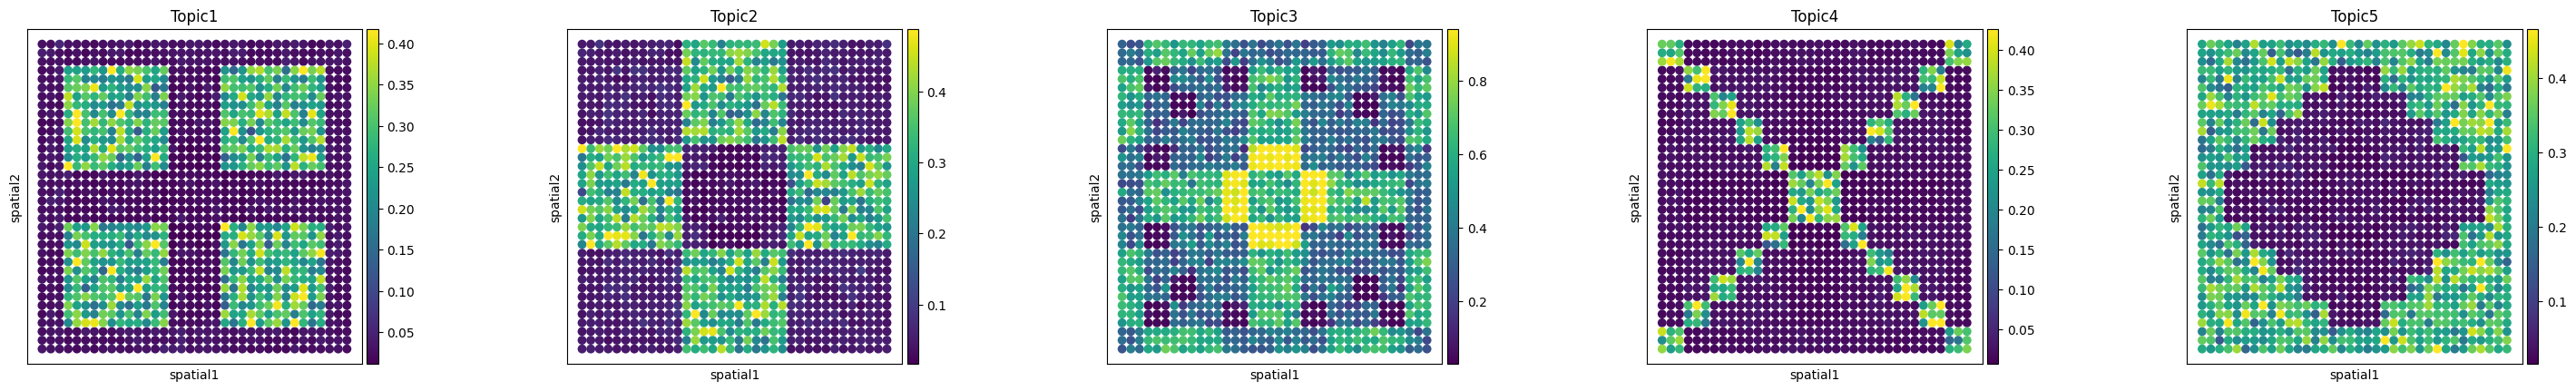

In [118]:
sctm.pl.spatial(adata, color = topic_prop.columns, size = 200, layer = "counts", vmax = 'p99', ncols = 5)

We plot the top 4 genes of each topic

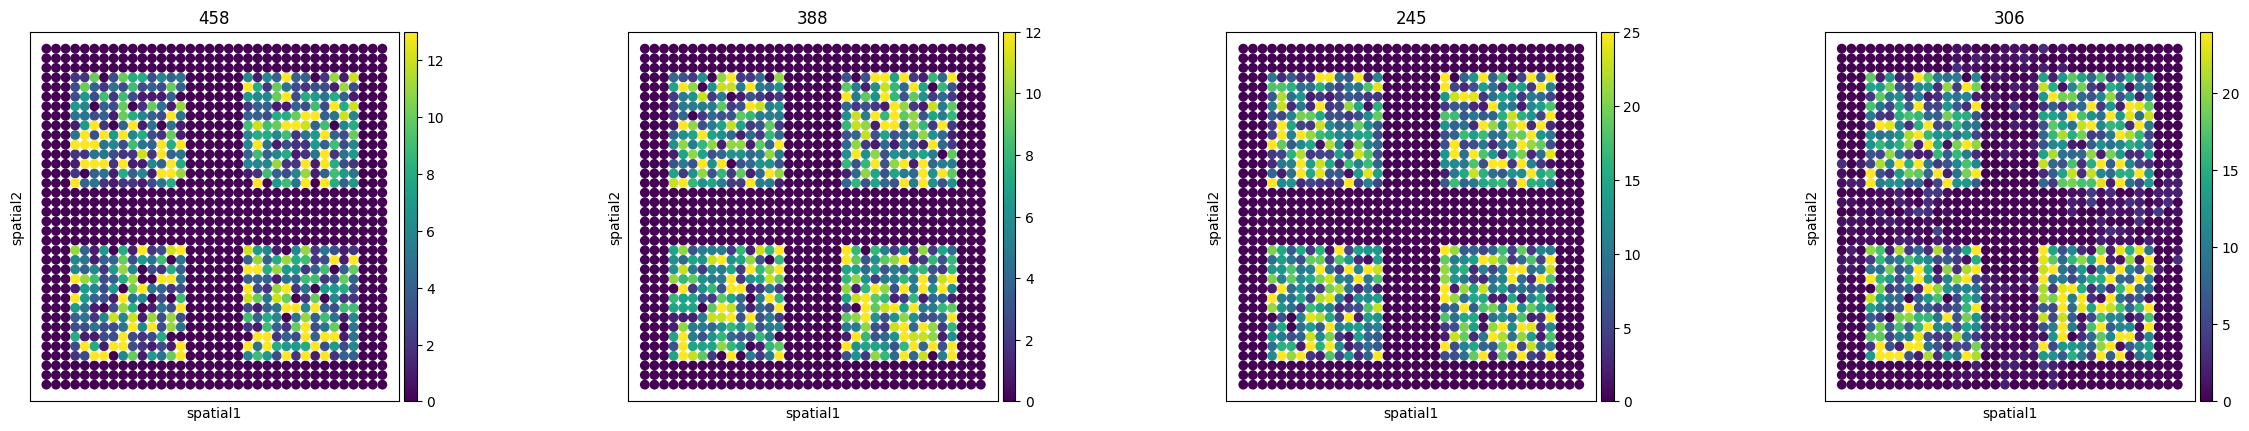

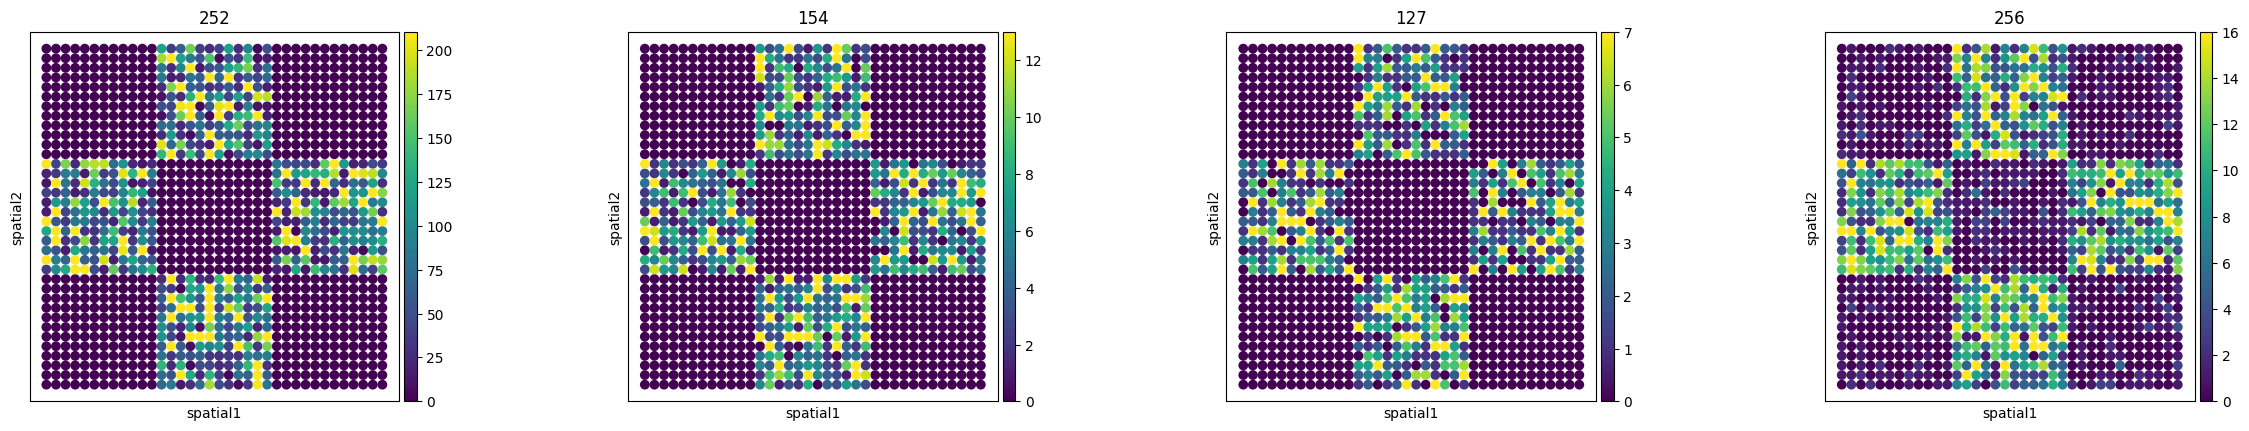

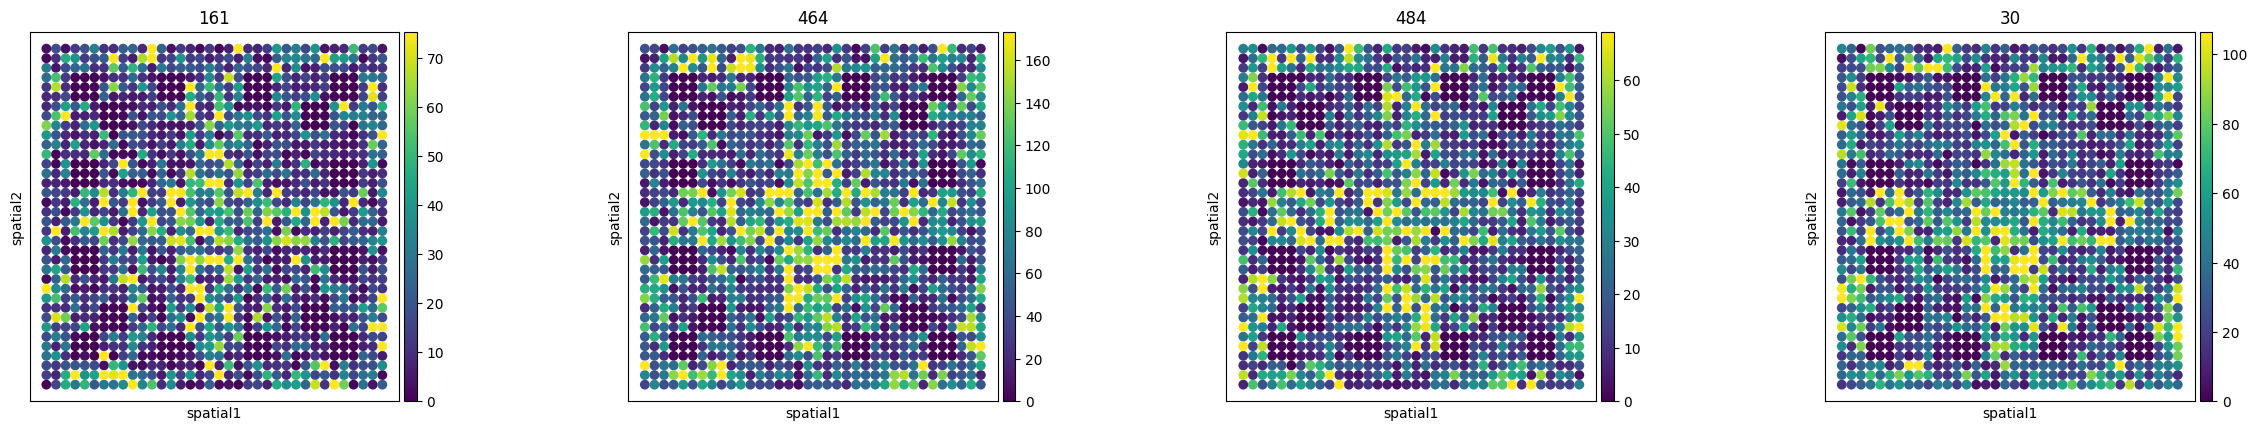

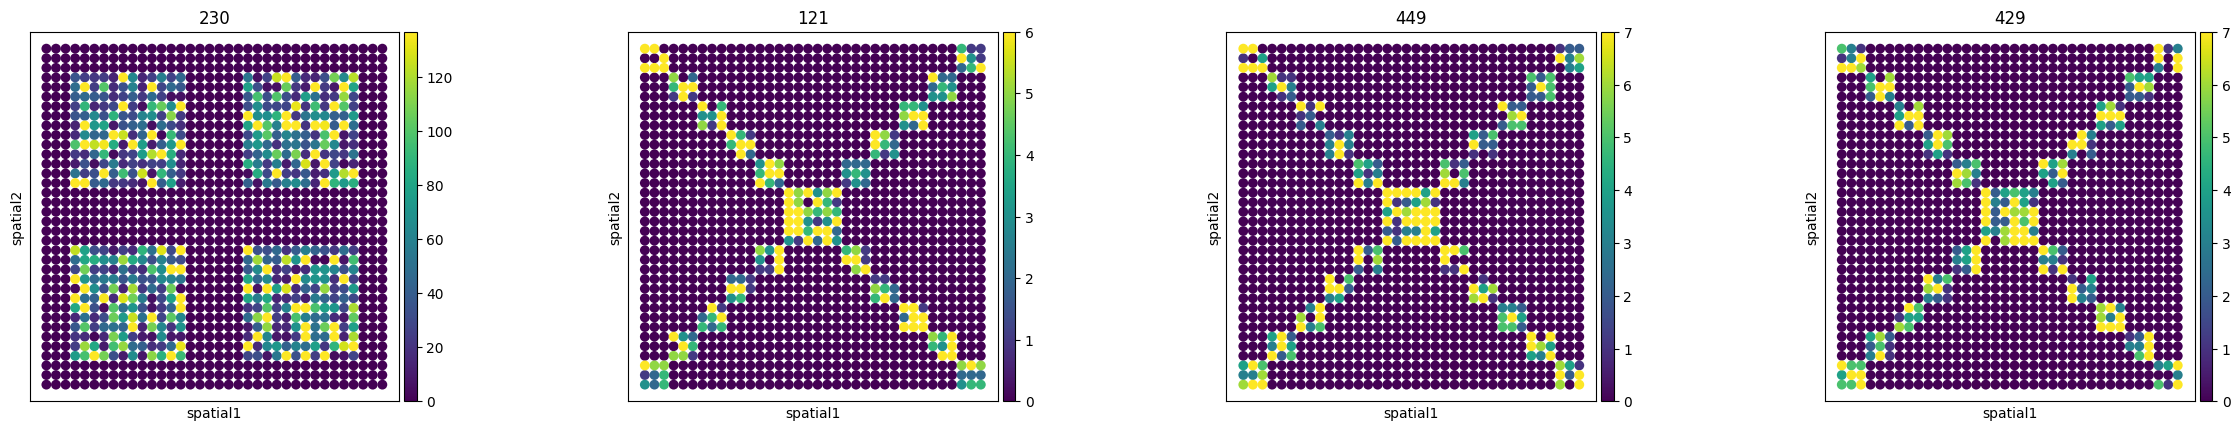

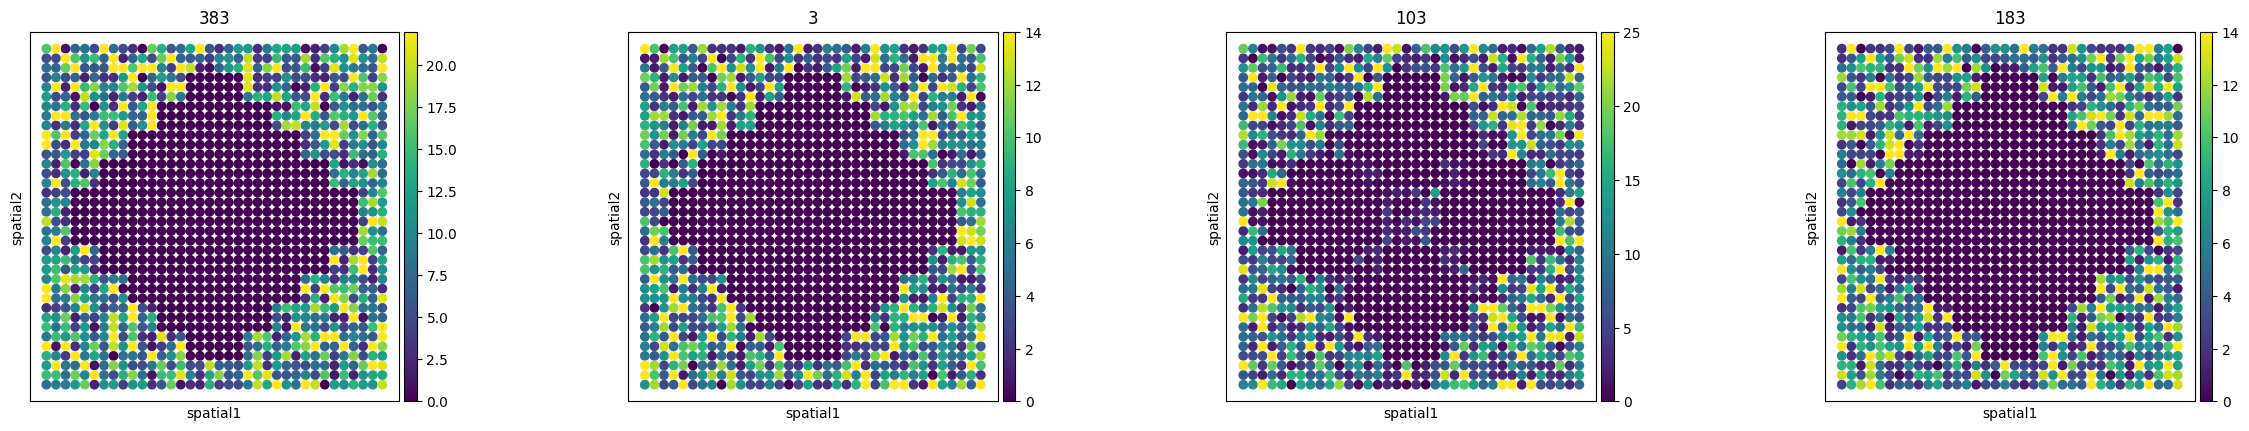

In [119]:
for topic in topic_prop.columns:
    sctm.pl.spatial(adata, color = beta.nlargest(4, topic).index, size = 200, layer = "counts", vmax = 'p95')

<Axes: >

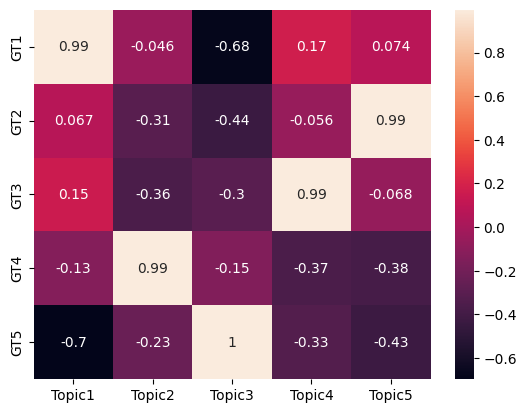

In [120]:
def corr(df1, df2):
    return pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1']

sns.heatmap(corr(topic_prop, gt), annot = True)